# Predict Future Sales

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

issues:
* check the unexepected high variations
* check when 0 and when sth
* check the high number of 0
those are big portion of the targets

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns; sns.set()
from dateutil.relativedelta import relativedelta

import plotly.express as px

In [2]:
from my_functions import merge_basic, convert_silver, completion_semi_gold, scaler, inversed_scale, consolidation_prediction, plot_prediction, preparing_to_predict, plot_metrics

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

### Data

In [4]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [5]:
train_merge = merge_basic(daily_train, test, 'left')

In [6]:
wholedata_silver = convert_silver(train_merge)

In [7]:
wholedata_silver.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,InTest,item_cnt_day,shopitem
0,2013-01-01,0,0,32,Кино - DVD,40,0,6.0,0-32
1,2013-01-01,0,0,33,Кино - Blu-Ray,37,0,3.0,0-33
2,2013-01-01,0,0,35,Кино - DVD,40,0,1.0,0-35
3,2013-01-01,0,0,43,Кино - DVD,40,0,1.0,0-43
4,2013-01-01,0,0,51,Музыка - MP3,57,0,2.0,0-51


<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

In [8]:
wholedata_silver.SaleDateMY.max()

Timestamp('2015-10-01 00:00:00')

In [9]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

In [10]:
whole_test_data = wholedata_silver[wholedata_silver.SaleDateMY.isin(test_dates)][['SaleDateMY','date_block_num','shop_id','item_id','item_cnt_day']]

#### hold-out Train

In [11]:
date_val = datetime.datetime(2015, 10, 1)

In [12]:
train_window = wholedata_silver[wholedata_silver.SaleDateMY < date_val ].copy()
val_window = wholedata_silver[wholedata_silver.SaleDateMY == date_val ][['SaleDateMY','shop_id','item_id','item_cnt_day']].copy()

In [13]:
train_window.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_category_name,item_category_id,InTest,item_cnt_day,shopitem
0,2013-01-01,0,0,32,Кино - DVD,40,0,6.0,0-32
1,2013-01-01,0,0,33,Кино - Blu-Ray,37,0,3.0,0-33
2,2013-01-01,0,0,35,Кино - DVD,40,0,1.0,0-35
3,2013-01-01,0,0,43,Кино - DVD,40,0,1.0,0-43
4,2013-01-01,0,0,51,Музыка - MP3,57,0,2.0,0-51


In [14]:
train_window.SaleDateMY.max(), train_window.SaleDateMY.min()

(Timestamp('2015-09-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [15]:
train_full = completion_semi_gold(train_window)

In [16]:
train_full.head()

,InTest,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order,MiguelId
0,0,2,27,2-27,19,2013-03-01,0.0,1,2-27-2013-03-01
1,0,2,66,2-66,37,2013-03-01,0.0,1,2-66-2013-03-01
2,0,2,77,2-77,40,2013-03-01,0.0,1,2-77-2013-03-01
3,0,2,97,2-97,40,2013-03-01,0.0,1,2-97-2013-03-01
4,0,2,99,2-99,37,2013-03-01,0.0,1,2-99-2013-03-01


In [17]:
train_full.shape

(11940673, 9)

### Exploration

Find unexpected variations (small variations) using months IDs, etc

In [20]:
poss_train = train_full.assign( poss = np.where(train_full.Sale > 0, 1, 0) )
poss_train['maxSale'] = poss_train.groupby(['shopitem']).Sale.transform(lambda x: x.max())

In [21]:
lag_train = poss_train.copy()
lag_train['SaleL1M'] = lag_train.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
lag_train = lag_train.assign(L0M_L1M = lag_train.Sale - lag_train.SaleL1M)

lag_train['maxVar'] = lag_train.groupby(['shopitem']).L0M_L1M.transform('max')
lag_train['minVar'] = lag_train.groupby(['shopitem']).L0M_L1M.transform('min')

lag_train = lag_train.assign( noVar = np.where(lag_train.L0M_L1M == 0, 1, 0) )
lag_train['countNoVar'] = lag_train.groupby(['shopitem']).noVar.transform('sum')

* even with full data - explostions seems to keep

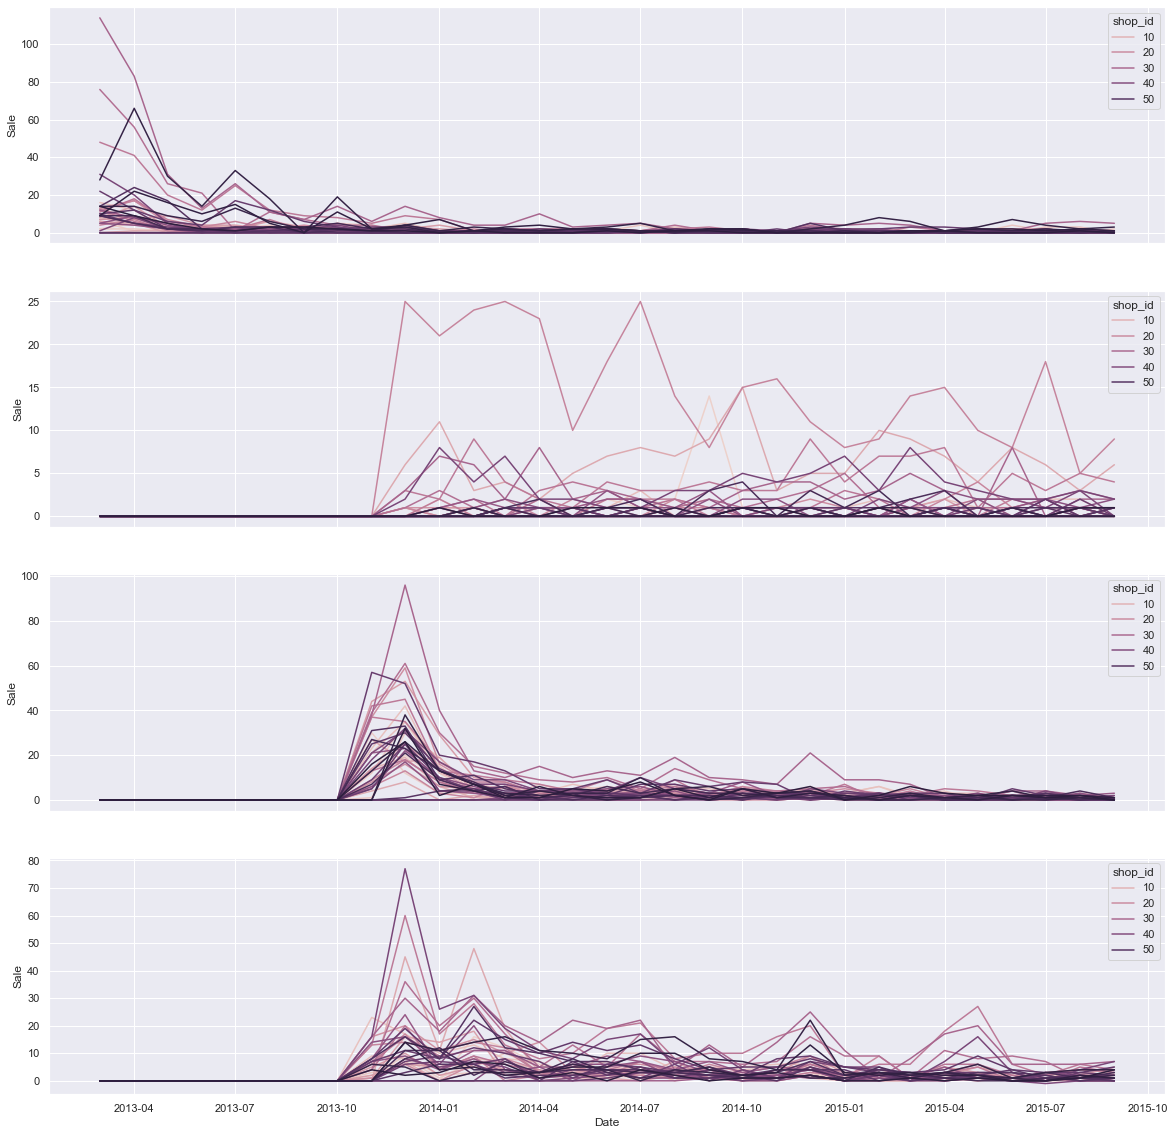

In [22]:
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(20,20), sharex=True)
ax = sns.lineplot(ax = axs[0] , data = lag_train[(lag_train.item_id == 21440) & (lag_train.InTest == 1)] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[1] , data = lag_train[(lag_train.item_id == 806) & (lag_train.InTest == 1)] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[2] , data = lag_train[(lag_train.item_id == 1495) & (lag_train.InTest == 1)] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[3] , data = lag_train[(lag_train.item_id == 5672) & (lag_train.InTest == 1)] , x="Date", y="Sale", hue = 'shop_id' )

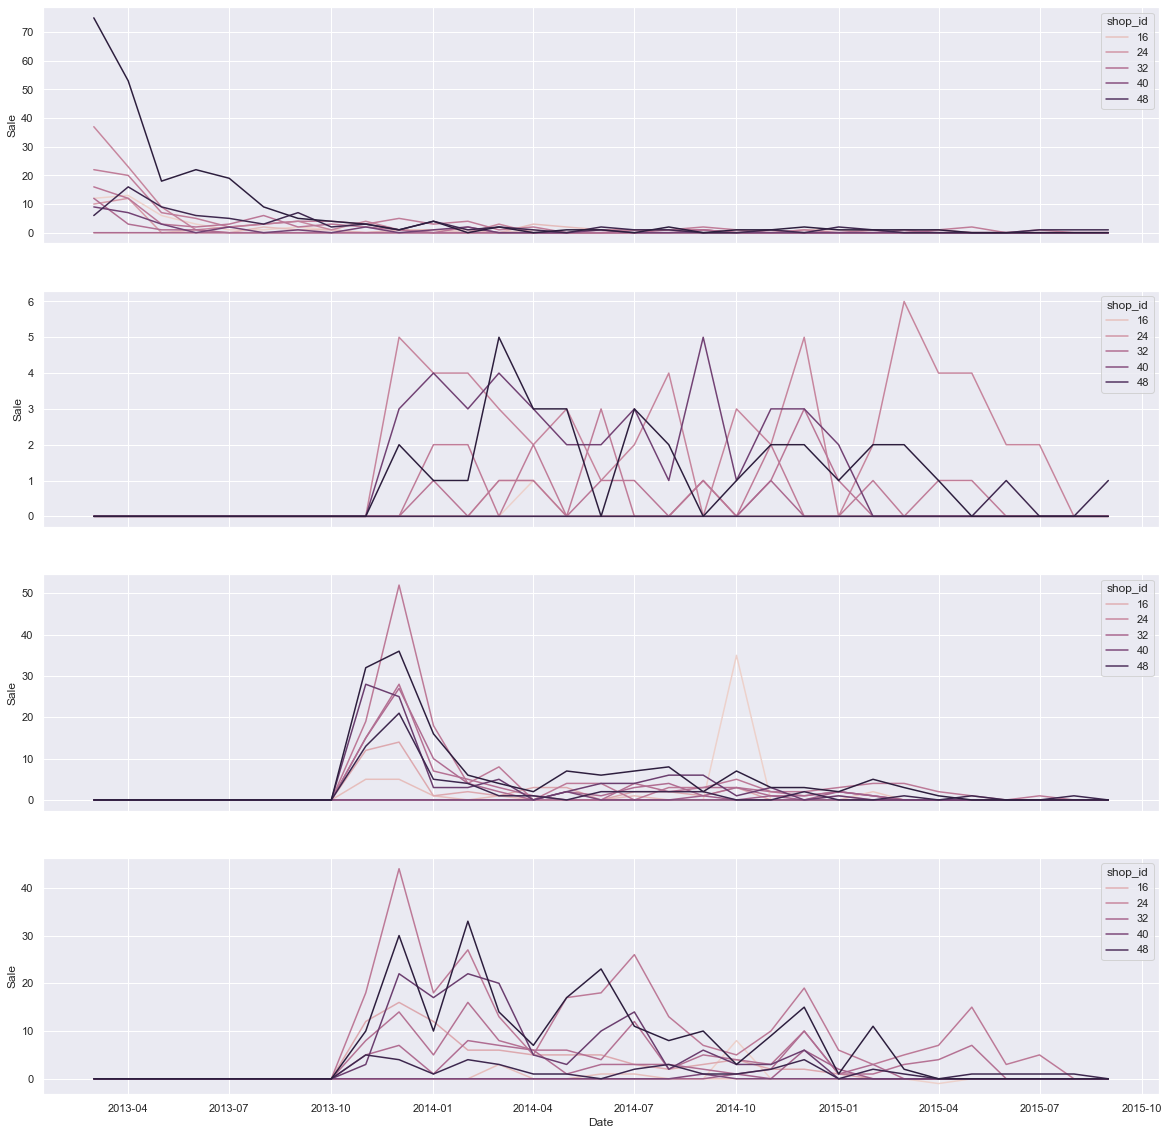

In [23]:
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(20,20), sharex=True)
ax = sns.lineplot(ax = axs[0] , data = lag_train[(lag_train.item_id == 21440) & (lag_train.InTest == 0)] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[1] , data = lag_train[(lag_train.item_id == 806) & (lag_train.InTest == 0)] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[2] , data = lag_train[(lag_train.item_id == 1495) & (lag_train.InTest == 0)] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[3] , data = lag_train[(lag_train.item_id == 5672) & (lag_train.InTest == 0)] , x="Date", y="Sale", hue = 'shop_id' )

In [22]:
lag_train.pivot_table(index= 'maxSale', columns = 'InTest', values = 'shopitem', aggfunc = 'count').reset_index().sort_values('maxSale').head(10)

InTest,maxSale,0,1
0,0.0,6541.0,1209.0
1,1.0,5394372.0,1452691.0
2,2.0,1541382.0,722424.0
3,3.0,592596.0,323020.0
4,4.0,307923.0,180141.0
5,5.0,191394.0,117707.0
6,6.0,127658.0,81747.0
7,7.0,93279.0,56513.0
8,8.0,69719.0,44516.0
9,9.0,50406.0,33201.0


In [23]:
lag_train.pivot_table(index= 'item_id', values = 'Sale', aggfunc = 'max').fillna(0).sort_values('Sale',ascending = False).iloc[1200:1250]

,Sale
item_id,
4362,20.0
4360,20.0
5046,20.0
18829,20.0
10211,20.0
1496,20.0
10120,20.0
15747,20.0
17715,20.0


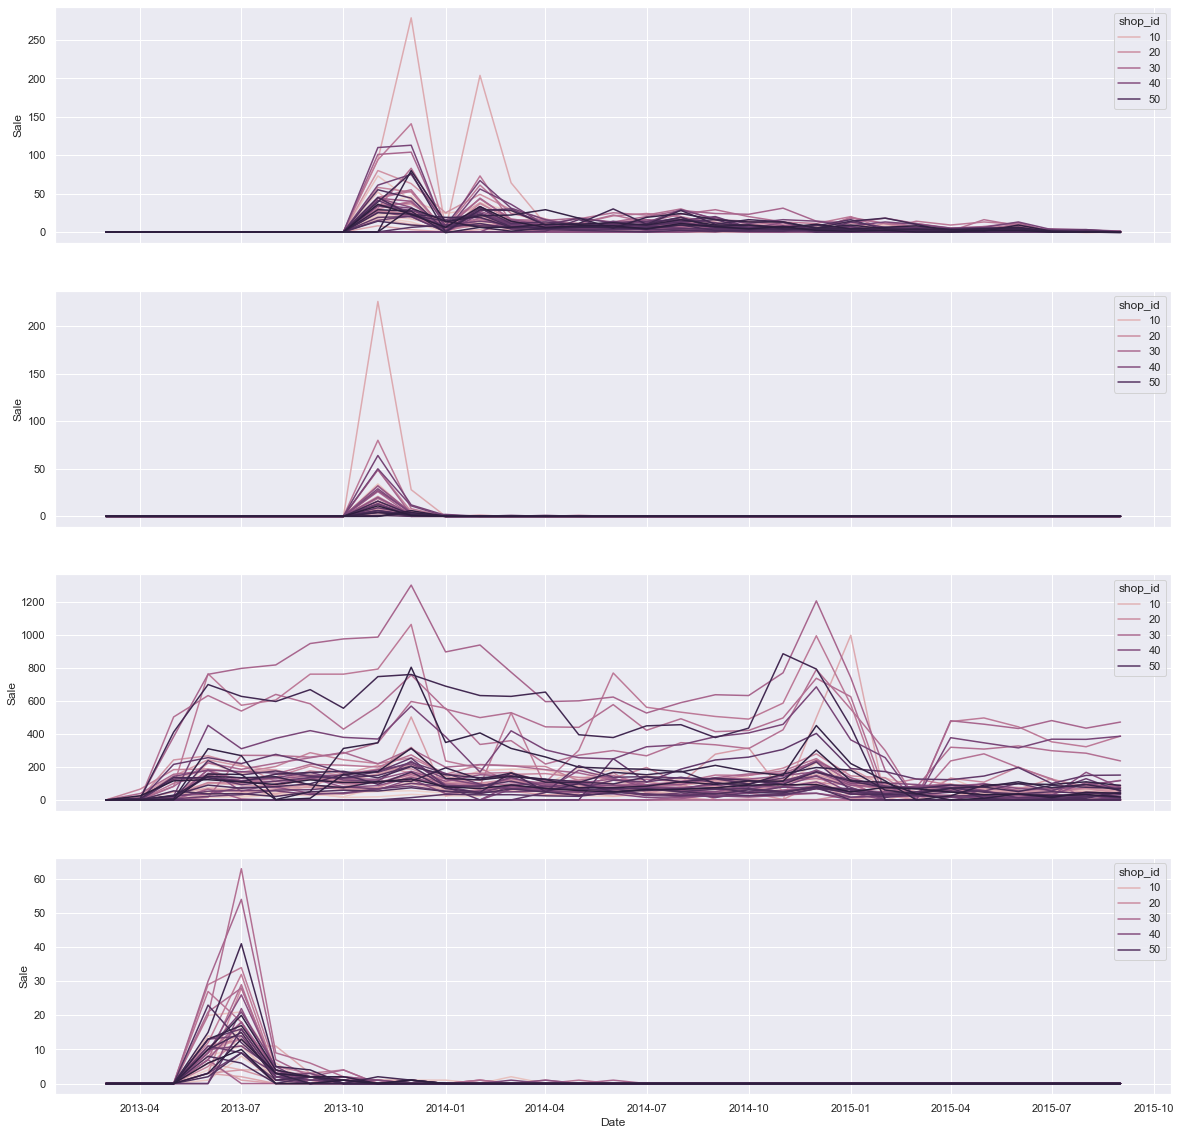

In [24]:
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(20,20), sharex=True)
ax = sns.lineplot(ax = axs[0] , data = lag_train[(lag_train.item_id == 6675) ] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[1] , data = lag_train[(lag_train.item_id == 1502) ] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[2] , data = lag_train[(lag_train.item_id == 20949) ] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[3] , data = lag_train[(lag_train.item_id == 6499) ] , x="Date", y="Sale", hue = 'shop_id' )

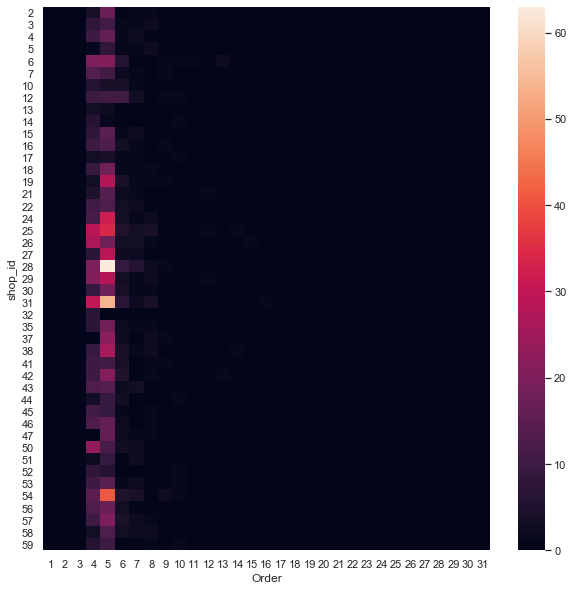

In [25]:
##6675,1502,6499, 20949
to_heat = lag_train[lag_train.item_id.isin([6499])]\
    .pivot_table(index= 'shop_id', columns = 'Order',values = 'Sale', aggfunc = 'max')\
    .fillna(0)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10), sharex=True)
ax = sns.heatmap(to_heat)

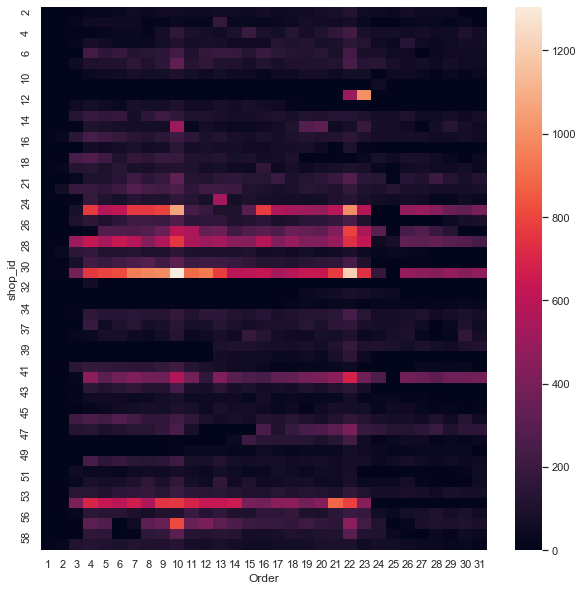

In [26]:
to_heat = lag_train[lag_train.item_id.isin([20949])]\
    .pivot_table(index= 'shop_id', columns = 'Order',values = 'Sale', aggfunc = 'max')\
    .fillna(0)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10), sharex=True)
ax = sns.heatmap(to_heat)

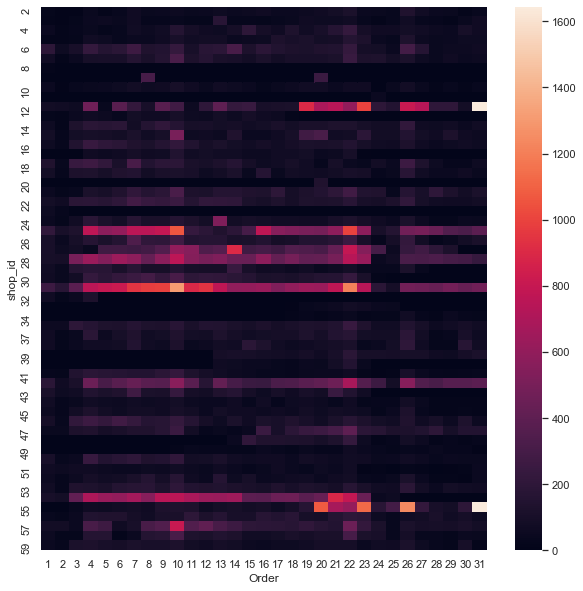

In [27]:
to_heat = lag_train\
    .pivot_table(index= 'shop_id', columns = 'Order',values = 'Sale', aggfunc = 'max')\
    .fillna(0)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10), sharex=True)
ax = sns.heatmap(to_heat)

In [28]:
lag_train[lag_train.item_id.isin([20949])].shop_id.unique()

array([11, 13, 17, 27, 29, 30, 32, 33, 40, 43, 51, 54,  2,  3,  4,  5,  6,
        7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35,
       37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 56, 57, 58,
       59], dtype=int64)

insights:
+ item by itsetf has it own information
* the shop have information by itselves as well

### My features

In [18]:
def balance_items_test(data, percentage_test = 0.30, gen_sample = 0.70):
    
    data = data.copy()
    
    ## data from not in test
    
    items_in_test = list(data[data.InTest == 1].shopitem.unique())
    items_in_test = [str(x) for x in items_in_test]
    
    items_no_test = list(data[data.InTest == 0].shopitem.unique())
    items_no_test = [str(x) for x in items_no_test]
    ncapture = int(round(len(items_no_test)*percentage_test,0 ))
    random.shuffle(items_no_test)
    items_no_test = items_no_test[0:ncapture]
    
    selected_items = items_in_test + items_no_test
    data = data[data.shopitem.isin(selected_items)]

    ## for general sample
    to_hide = int( round(len(data.shopitem.unique())*gen_sample,0 ))
    items = list(data.shopitem.unique())
    items = [str(x) for x in items]
    random.shuffle(items)
    
    keep_items = items[0:to_hide]
    data_result = data[data.shopitem.astype('str').isin(keep_items)]
    
    return data_result

In [22]:
data_train_selected = balance_items_test(train_full, percentage_test = 0.30, gen_sample = 0.10)

<b> Item Feature

In [31]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.50)

def q3(x):
    return x.quantile(0.90)

date_max = data_train_selected.Date.max()
date_max = datetime.datetime(date_max.year, date_max.month, date_max.day)
begin_date = date_max - relativedelta(months = 14)

df_feature = data_train_selected[data_train_selected.Date >= begin_date]\
    .groupby(['item_id','Date'])\
    .agg( lowValueItem = ('Sale', q1), 
        medianValueItem = ('Sale',q2),
        highValueItem = ('Sale',q3),
        maxValueItem = ('Sale','max'))\
    .reset_index()
df_feature['RangeValueItem'] = df_feature.maxValueItem - df_feature.medianValueItem
## lags 
df_feature['L1medianValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['medianValueItem'].shift(1)
df_feature['L2medianValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['medianValueItem'].shift(2)
df_feature['L3medianValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['medianValueItem'].shift(3)
df_feature['L4medianValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['medianValueItem'].shift(4)
df_feature['L12medianValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['medianValueItem'].shift(12)
df_feature['L13medianValueItem'] = df_feature.sort_values('Date').groupby(['item_id'])['medianValueItem'].shift(13)

df_feature = df_feature.assign(L1M_L2MItem = df_feature.L1medianValueItem - df_feature.L2medianValueItem)
df_feature = df_feature.assign(L1M_L3MItem = df_feature.L1medianValueItem - df_feature.L3medianValueItem)
df_feature = df_feature.assign(L1M_L4MItem = df_feature.L1medianValueItem - df_feature.L4medianValueItem)
df_feature = df_feature.assign(L1M_L12MItem = df_feature.L1medianValueItem - df_feature.L12medianValueItem)
df_feature = df_feature.assign(L1M_L13MItem = df_feature.L1medianValueItem - df_feature.L13medianValueItem)

df_feature = df_feature.drop(columns = ['L13medianValueItem','L12medianValueItem','L3medianValueItem','L3medianValueItem','L2medianValueItem',
                                       'L1medianValueItem'])

## count recent 0
df_feature['count0'] = np.where(df_feature.L1M_L2MItem == 0,1,0)
df_feature['Roll0L1Item'] = df_feature.sort_values('Date').groupby(['item_id']).count0.transform(lambda x: x.rolling(4, 1).sum())
df_feature = df_feature.drop(columns = ['count0'])


In [32]:
df_feature[df_feature.item_id == 32]

,item_id,Date,lowValueItem,medianValueItem,highValueItem,maxValueItem,RangeValueItem,L4medianValueItem,L1M_L2MItem,L1M_L3MItem,L1M_L4MItem,L1M_L12MItem,L1M_L13MItem,Roll0L1Item
75,32,2014-07-01,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0
76,32,2014-08-01,0.0,0.0,1.6,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0
77,32,2014-09-01,0.0,0.0,1.0,1.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,1
78,32,2014-10-01,0.0,0.0,1.6,2.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,2
79,32,2014-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,3
80,32,2014-12-01,0.0,0.0,0.6,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,4
81,32,2015-01-01,0.0,0.0,0.6,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,4
82,32,2015-02-01,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,4
83,32,2015-03-01,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,4
84,32,2015-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,4


<b> Shop feature

In [33]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.50)

def q3(x):
    return x.quantile(0.90)

date_max = data_train_selected.Date.max()
date_max = datetime.datetime(date_max.year, date_max.month, date_max.day)
begin_date = date_max - relativedelta(months = 14)

df_feature = data_train_selected[data_train_selected.Date >= begin_date]\
    .groupby(['shop_id','Date'])\
    .agg( lowValueShop = ('Sale', q1), 
        medianValueShop = ('Sale',q2),
        highValueShop = ('Sale',q3),
        maxValueShop = ('Sale','max'))\
    .reset_index()
df_feature['RangeValueShop'] =  df_feature.maxValueShop - df_feature.medianValueShop
## lags 
df_feature['L1medianValueShop'] = df_feature.sort_values('Date').groupby(['shop_id'])['medianValueShop'].shift(1)
df_feature['L2medianValueShop'] = df_feature.sort_values('Date').groupby(['shop_id'])['medianValueShop'].shift(2)
df_feature['L3medianValueShop'] = df_feature.sort_values('Date').groupby(['shop_id'])['medianValueShop'].shift(3)
df_feature['L4medianValueShop'] = df_feature.sort_values('Date').groupby(['shop_id'])['medianValueShop'].shift(4)
df_feature['L12medianValueShop'] = df_feature.sort_values('Date').groupby(['shop_id'])['medianValueShop'].shift(12)
df_feature['L13medianValueShop'] = df_feature.sort_values('Date').groupby(['shop_id'])['medianValueShop'].shift(13)

df_feature = df_feature.assign(L1M_L2MShop = df_feature.L1medianValueShop - df_feature.L2medianValueShop)
df_feature = df_feature.assign(L1M_L3MShop = df_feature.L1medianValueShop - df_feature.L3medianValueShop)
df_feature = df_feature.assign(L1M_L4MShop = df_feature.L1medianValueShop - df_feature.L4medianValueShop)
df_feature = df_feature.assign(L1M_L12MShop = df_feature.L1medianValueShop - df_feature.L12medianValueShop)
df_feature = df_feature.assign(L1M_L13MShop = df_feature.L1medianValueShop - df_feature.L13medianValueShop)

df_feature = df_feature.drop(columns = ['L13medianValueShop','L12medianValueShop','L3medianValueShop','L3medianValueShop','L2medianValueShop',
                                       'L1medianValueShop'])

## count recent 0
df_feature['count0'] = np.where(df_feature.L1M_L2MShop == 0,1,0)
df_feature['Roll0L1Shop'] = df_feature.sort_values('Date').groupby(['shop_id']).count0.transform(lambda x: x.rolling(4, 1).sum())
df_feature = df_feature.drop(columns = ['count0'])

In [34]:
df_feature

,shop_id,Date,lowValueShop,medianValueShop,highValueShop,maxValueShop,RangeValueShop,L4medianValueShop,L1M_L2MShop,L1M_L3MShop,L1M_L4MShop,L1M_L12MShop,L1M_L13MShop,Roll0L1Shop
0,2,2014-07-01,0.0,0.0,0.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,2014-08-01,0.0,0.0,1.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,2014-09-01,0.0,0.0,1.0,11.0,11.0,NaN,0.0,NaN,NaN,NaN,NaN,1
3,2,2014-10-01,0.0,0.0,1.0,18.0,18.0,NaN,0.0,0.0,NaN,NaN,NaN,2
4,2,2014-11-01,0.0,0.0,1.0,8.0,8.0,0.0,0.0,0.0,0.0,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850,59,2015-05-01,0.0,0.0,1.0,6.0,6.0,0.0,0.0,0.0,0.0,NaN,NaN,4
851,59,2015-06-01,0.0,0.0,1.0,6.0,6.0,0.0,0.0,0.0,0.0,NaN,NaN,4
852,59,2015-07-01,0.0,0.0,1.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,NaN,4
853,59,2015-08-01,0.0,0.0,1.0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,4


### Further features

#### index search

In [20]:
data_train_selected = balance_items_test(train_full, percentage_test = 0.30, gen_sample = 0.10)

In [21]:
data_train_selected.shape

(585404, 9)

In [22]:
data_train_selected.Date.min(), data_train_selected.Date.max()

(Timestamp('2013-03-01 00:00:00'), Timestamp('2015-09-01 00:00:00'))

#### item search

In [28]:
data_train_selected['itemMax'] = data_train_selected.groupby(['shopitem']).Sale.transform('max')
data_train_selected['itemMin'] = data_train_selected.groupby(['shopitem']).Sale.transform('min')
data_train_selected['SaleScaled'] = ((data_train_selected.Sale - data_train_selected.itemMin)/(data_train_selected.itemMax - data_train_selected.itemMin))

In [29]:
data_train_selected.head()

,InTest,shop_id,item_id,shopitem,item_category_id,Date,Sale,Order,MiguelId,itemMax,itemMin,SaleScaled
6,0,2,258,2-258,45,2013-03-01,0.0,1,2-258-2013-03-01,1.0,0.0,0.0
21,0,2,934,2-934,40,2013-03-01,0.0,1,2-934-2013-03-01,2.0,0.0,0.0
27,0,2,951,2-951,23,2013-03-01,0.0,1,2-951-2013-03-01,3.0,0.0,0.0
33,0,2,989,2-989,67,2013-03-01,0.0,1,2-989-2013-03-01,1.0,0.0,0.0
76,0,2,1448,2-1448,28,2013-03-01,0.0,1,2-1448-2013-03-01,10.0,0.0,0.0


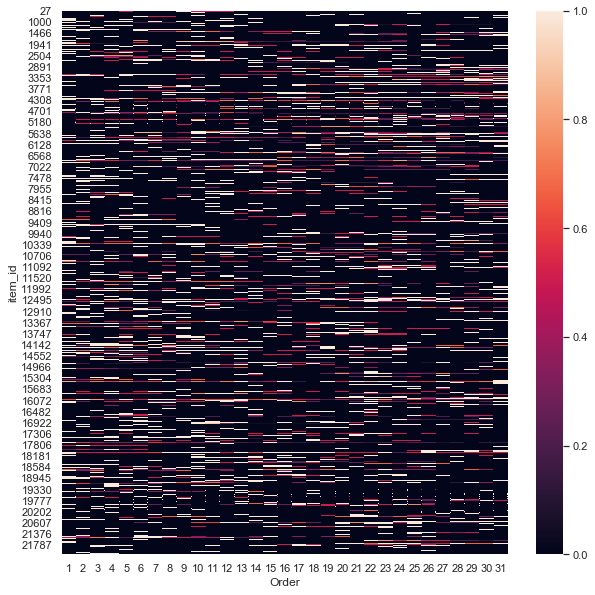

In [30]:
to_heat = data_train_selected\
    .pivot_table(index= 'item_id', columns = 'Order',values = 'SaleScaled', aggfunc = 'max')\
    .fillna(0)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10), sharex=True)
ax = sns.heatmap(to_heat)

sorting

In [31]:
df_plot = data_train_selected.pivot_table(index= ['item_id','item_category_id','Order'] ,values = 'SaleScaled', aggfunc = 'max').reset_index()
df_plot['possnumb'] = np.where(df_plot.SaleScaled > 0 , 1,0)
df_plot['maxOrder'] = df_plot.groupby(['item_id','possnumb']).cumcount() + 1
df_plot['maxOrder'] = np.where(df_plot.possnumb == 0 , 0, df_plot['maxOrder'] )
df_plot['OrderGot'] = np.where(df_plot.maxOrder == 1, df_plot.Order,0)
df_plot['OrderGot'] = df_plot.groupby(['item_id']).OrderGot.transform('sum')
df_plot['possCounts'] = df_plot.groupby(['item_id']).SaleScaled.transform('sum')

df_plot_heat = df_plot.pivot_table(index= ['item_id','OrderGot','possCounts'],columns = 'Order' ,values = 'SaleScaled', aggfunc = 'sum').fillna(0)\
    .reset_index()\
    .sort_values(['OrderGot','possCounts']).drop(columns = ['OrderGot','possCounts'])\
    .set_index('item_id')

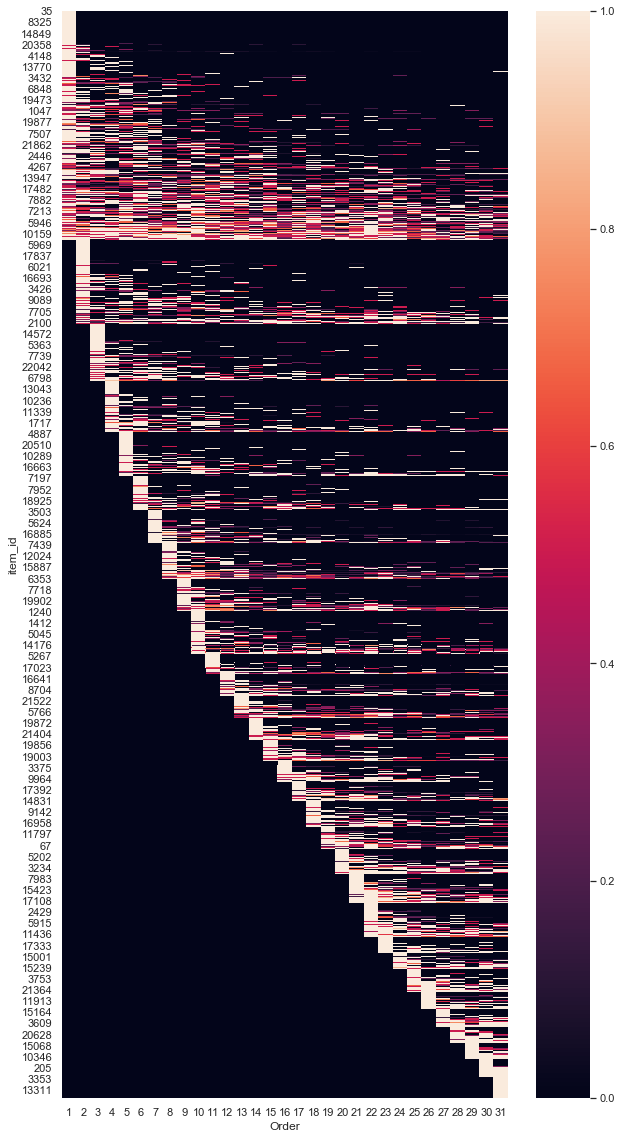

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,20), sharex=True)
ax = sns.heatmap(df_plot_heat)

<b> one interaction
* if items after explosion has at least 3 observations, otherwise take some other features

<b> feature:
* month or order explosion and count of possitives
* if item not in the historic data aja!
* if just exploted, then replicate another explotion

<b> the features

first, explosion dates or orders

In [33]:
##For this maybe try to capture as much data as possible

df_feature = data_train_selected.pivot_table(index= ['item_id','item_category_id','Order'] ,values = ['Sale'], aggfunc = 'max').reset_index()
df_feature['possnumb'] = np.where(df_feature.Sale > 0 , 1,0)
df_feature['maxOrder'] = df_feature.groupby(['item_id','possnumb']).cumcount() + 1
df_feature['maxOrder'] = np.where(df_feature.possnumb == 0 , 0, df_feature['maxOrder'] )
df_feature['OrderGot'] = np.where(df_feature.maxOrder == 1, df_feature.Order,0)
df_feature['OrderGot'] = df_feature.groupby(['item_id']).OrderGot.transform('sum')
df_feature['possCounts'] = df_feature.groupby(['item_id']).Sale.transform('sum')

### the reorder gives the date x gap to OrderGot
df_feature['reorder'] = df_feature['Order'] - df_feature['OrderGot'] 

### the lag diff gives the estimated variation
df_feature['SaleL1M'] = df_feature.sort_values('Order').groupby(['item_id'])['Sale'].shift(1)
df_feature = df_feature.assign(L1M_L2M = df_feature.Sale - df_feature.SaleL1M) 

In [34]:
## feature 1 order of start
df_feature.groupby('item_id').agg(OrderStarted = ('OrderGot','max')).reset_index().head()

,item_id,OrderStarted
0,27,15
1,30,1
2,31,1
3,32,1
4,33,1


In [155]:
## feature 2 items that existed
df_feature.item_id.unique()

array([   17,    20,    28, ..., 22163, 22164, 22167], dtype=int64)

In [169]:
## feature 3 percentile variation for 3 times after start
df_feature[(df_feature.reorder >= 0) & (df_feature.reorder <= 2)]\
    .groupby(['OrderGot', 'reorder']).agg(EstimVar = ('L1M_L2M','mean'))\
    .reset_index().sort_values(['OrderGot','reorder'],ascending = False)\
    .groupby('reorder').agg(EstimVar = ('EstimVar','mean'))\
    .head(20)

,EstimVar
reorder,
0,3.517628
1,-1.402314
2,-0.698077


In [35]:
df_feature[(df_feature.item_id == 27) & (df_feature.reorder >= 0)]

,item_id,item_category_id,Order,Sale,possnumb,maxOrder,OrderGot,possCounts,reorder,SaleL1M,L1M_L2M
14,27,19,15,1.0,1,1,15,1.0,0,0.0,1.0
15,27,19,16,0.0,0,0,15,1.0,1,1.0,-1.0
16,27,19,17,0.0,0,0,15,1.0,2,0.0,0.0
17,27,19,18,0.0,0,0,15,1.0,3,0.0,0.0
18,27,19,19,0.0,0,0,15,1.0,4,0.0,0.0
19,27,19,20,0.0,0,0,15,1.0,5,0.0,0.0
20,27,19,21,0.0,0,0,15,1.0,6,0.0,0.0
21,27,19,22,0.0,0,0,15,1.0,7,0.0,0.0
22,27,19,23,0.0,0,0,15,1.0,8,0.0,0.0
23,27,19,24,0.0,0,0,15,1.0,9,0.0,0.0


#### shop search

In [105]:
df_plot = data_train_selected.pivot_table(index= ['shop_id','Order'] ,values = 'SaleScaled', aggfunc = 'mean').reset_index()
df_plot['possnumb'] = np.where(df_plot.SaleScaled > 0 , 1,0)
df_plot['maxOrder'] = df_plot.groupby(['shop_id','possnumb']).cumcount() + 1
df_plot['maxOrder'] = np.where(df_plot.possnumb == 0 , 0, df_plot['maxOrder'] )
df_plot['OrderGot'] = np.where(df_plot.maxOrder == 1, df_plot.Order,0)
df_plot['OrderGot'] = df_plot.groupby(['shop_id']).OrderGot.transform('sum')
df_plot['possCounts'] = df_plot.groupby(['shop_id']).SaleScaled.transform('sum')

df_plot_heat = df_plot.pivot_table(index= ['shop_id','OrderGot','possCounts'],columns = 'Order' ,values = 'SaleScaled', aggfunc = 'sum').fillna(0)\
    .reset_index()\
    .sort_values(['OrderGot','possCounts']).drop(columns = ['OrderGot','possCounts'])\
    .set_index('shop_id')

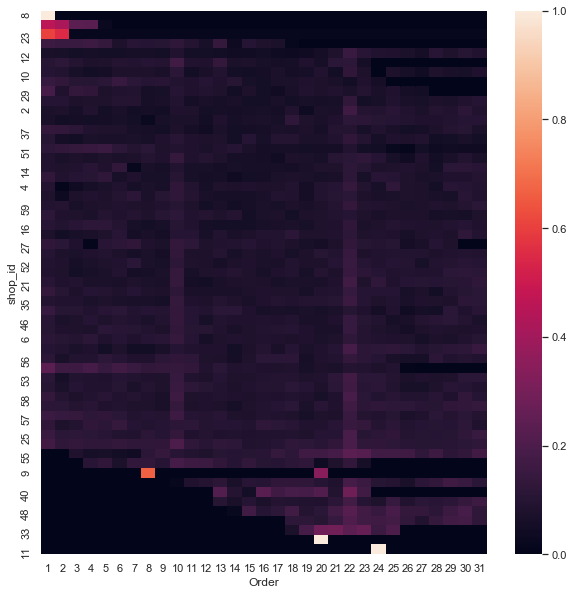

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10), sharex=True)
ax = sns.heatmap(df_plot_heat)

### Cluster time series

In [38]:
date_max = data_train_selected.Date.max()
begin_date = date_max - relativedelta(months = 4)

In [39]:
pivot = data_train_selected[data_train_selected.Date >= begin_date].pivot_table(index = ['shop_id','item_id'], columns = 'Order', values = 'Sale', aggfunc = 'sum').reset_index()

In [40]:
pivot.head()

Order,shop_id,item_id,27,28,29,30,31
0,2,464,2.0,0.0,0.0,0.0,0.0
1,2,687,0.0,0.0,1.0,0.0,0.0
2,2,1090,0.0,1.0,0.0,0.0,1.0
3,2,1387,0.0,0.0,0.0,0.0,0.0
4,2,1389,0.0,0.0,0.0,2.0,0.0


In [41]:
pivot.shape

(18884, 7)

In [42]:
from sklearn.cluster import KMeans

In [43]:
X = pivot[pivot.columns[2:]]

In [44]:
kmeans = KMeans(n_clusters = 30, random_state=0).fit(X)

In [45]:
pivot['labels'] = kmeans.labels_

In [46]:
pivot.head()

Order,shop_id,item_id,27,28,29,30,31,labels
0,2,464,2.0,0.0,0.0,0.0,0.0,28
1,2,687,0.0,0.0,1.0,0.0,0.0,22
2,2,1090,0.0,1.0,0.0,0.0,1.0,15
3,2,1387,0.0,0.0,0.0,0.0,0.0,0
4,2,1389,0.0,0.0,0.0,2.0,0.0,11


In [55]:
ids = ['item_id','shop_id','labels']
varis = [x for x in pivot.columns if x not in ids]
unpivot = pivot.melt(id_vars= ids, value_vars = varis, var_name='Order', value_name='Sale')

In [56]:
unpivot.head()

,item_id,shop_id,labels,Order,Sale
0,464,2,28,27,2.0
1,687,2,22,27,0.0
2,1090,2,15,27,0.0
3,1387,2,0,27,0.0
4,1389,2,11,27,0.0


In [57]:
df = unpivot.groupby('item_id').agg(countunique = ('labels','nunique'),
                                   count = ('labels','count'),
                                   set = ('labels', lambda x: set(x))  ).reset_index()
df.sort_values('countunique',ascending = False)

,item_id,countunique,count,set
6587,16790,8,45,"{0, 9, 11, 15, 16, 19, 21, 22}"
6334,16167,7,50,"{0, 9, 11, 15, 19, 22, 28}"
3342,9355,7,50,"{0, 9, 11, 15, 21, 26, 27}"
5402,14228,7,50,"{0, 9, 11, 15, 16, 20, 22}"
8676,22087,6,30,"{9, 11, 15, 16, 19, 22}"
...,...,...,...,...
3421,9540,1,5,{0}
3420,9539,1,15,{0}
3419,9535,1,15,{0}
3417,9520,1,5,{0}


In [59]:
unpivot['countLabel'] = unpivot.groupby('item_id').labels.transform('nunique')

In [61]:
unpivot[unpivot.item_id == 687]

,item_id,shop_id,labels,Order,Sale,countLabel
1,687,2,22,27,0.0,3
1290,687,6,0,27,0.0,3
6288,687,24,9,27,4.0,3
16042,687,53,0,27,0.0,3
18885,687,2,22,28,0.0,3
20174,687,6,0,28,0.0,3
25172,687,24,9,28,0.0,3
34926,687,53,0,28,0.0,3
37769,687,2,22,29,1.0,3
39058,687,6,0,29,0.0,3
